<a href="https://colab.research.google.com/github/calebskim/Deep-Learning-Assignment-4/blob/main/DeepLearningAssignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install ucimlrepo

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Add
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [32]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
Y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [33]:
# Let's see what y looks like first
print(Y.value_counts())
y_binary = (Y.iloc[:, 0] == 1).astype(int)

# splitting the data first
split_idx = int(0.8 * X.shape[0])
X_train = X.iloc[:split_idx].copy()
X_val   = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_val   = y.iloc[split_idx:].copy()

Cover_Type
2             283301
1             211840
3              35754
7              20510
6              17367
5               9493
4               2747
Name: count, dtype: int64


In [34]:
# normalizing by the column names
numerical_cols = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# seperating vs numerical and categorical
X_train_num = X_train[numerical_cols]
X_val_num   = X_val[numerical_cols]
X_train_cat = X_train.drop(columns=numerical_cols)
X_val_cat   = X_val.drop(columns=numerical_cols)

# scaler normalizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_val_scaled   = scaler.transform(X_val_num)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train.index)
X_val_scaled_df   = pd.DataFrame(X_val_scaled, columns=numerical_cols, index=X_val.index)

# Final processed features
X_train_processed = pd.concat([X_train_scaled_df, X_train_cat], axis=1)
X_val_processed   = pd.concat([X_val_scaled_df, X_val_cat], axis=1)

# encoding the targets
y_train_idx = y_train.values.ravel() - 1
y_val_idx   = y_val.values.ravel() - 1

y_train_encoded = to_categorical(y_train_idx)
y_val_encoded   = to_categorical(y_val_idx)

In [35]:
# selecting a single batch (128)
X_batch = X_train_processed.iloc[:128]
y_batch = y_train_encoded[:128]

# building the actual model
input_dim = X_train_processed.shape[1]
num_classes = y_train_encoded.shape[1]

inputs = Input(shape=(input_dim,), name="Input")

# initial dense layer
base = Dense(64, activation="relu", name="Init_Dense")(inputs)

# the residual block
res_1 = Dense(64, activation="relu", name="Res_1")(base)
res_2 = Dense(64, activation="relu", name="Res_2")(res_1)
res_proj = Dense(64, activation=None, name="Res_Projection")(base)
res_out = Add(name="Residual_Sum")([res_2, res_proj])

# the middle layers
mid_1 = Dense(64, activation="relu", name="Mid_1")(res_out)
mid_2 = Dense(64, activation="relu", name="Mid_2")(mid_1)

# skip connection after residual -> added to mid output
skip = Dense(64, activation="linear", name="Skip_From_Res")(res_out)
merged = Add(name="Skip_Add")([mid_2, skip])

# final layers
final_1 = Dense(64, activation="relu", name="Final_1")(merged)
final_2 = Dense(64, activation="relu", name="Final_2")(final_1)

# output
output = Dense(num_classes, activation="softmax", name="Output")(final_2)

# model summary
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 54)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Init_Dense (Dense)        │ (None, 64)             │          3,520 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Res_1 (Dense)             │ (None, 64)             │          4,160 │ Init_Dense[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Res_2 (Dense)             │ (None, 64)             │          4,160 │ Res_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Res_Projection (Dense)    │ (None, 64)             │          4,160 │ Init_Dense[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Residual_Sum (Add)        │ (None, 64)             │              0 │ Res_2[0][0],           │
│                           │                        │                │ Res_Projection[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Mid_1 (Dense)             │ (None, 64)             │          4,160 │ Residual_Sum[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Mid_2 (Dense)             │ (None, 64)             │          4,160 │ Mid_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Skip_From_Res (Dense)     │ (None, 64)             │          4,160 │ Residual_Sum[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Skip_Add (Add)            │ (None, 64)             │              0 │ Mid_2[0][0],           │
│                           │                        │                │ Skip_From_Res[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Final_1 (Dense)           │ (None, 64)             │          4,160 │ Skip_Add[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Final_2 (Dense)           │ (None, 64)             │          4,160 │ Final_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 7)              │            455 │ Final_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 37,255 (145.53 KB)

 Trainable params: 37,255 (145.53 KB)

 Non-trainable params: 0 (0.00 B)

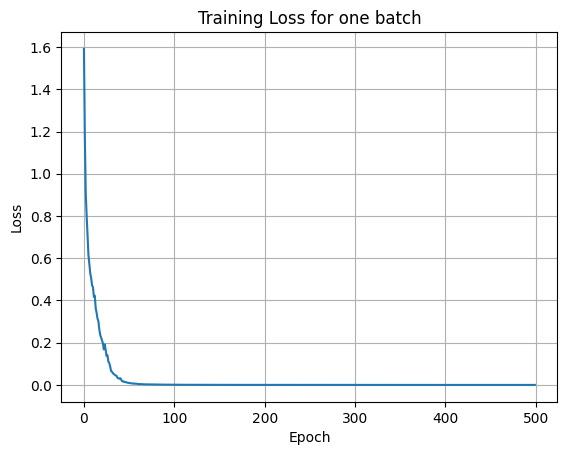

In [36]:
# training the model with epochs = 500
history = model.fit(X_batch, y_batch, epochs=500, verbose=0)

# plotting the training loss
plt.plot(history.history['loss'])
plt.title("Training Loss for one batch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [37]:
train_loss, train_acc = model.evaluate(X_batch, y_batch, verbose=0)
val_loss, val_acc = model.evaluate(X_val_processed, y_val_encoded, verbose=0)

print(f"\nNumber of parameters: {model.count_params()}")
print(f"Final training loss (on 1 batch): {train_loss:.4f}")
print(f"Final validation loss: {val_loss:.4f}")

# also trying to see validation accuracy
print(f"Train accuracy: {train_acc:.4f}")
print(f"Val accuracy: {val_acc:.4f}")


Number of parameters: 37255
Final training loss (on 1 batch): 0.0000
Final validation loss: 8.9991
Train accuracy: 1.0000
Val accuracy: 0.3830


In [29]:
# saving architecture for visualization
model.save("model_overfit.h5")